
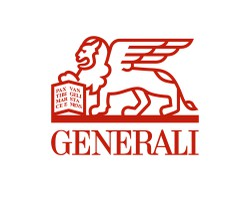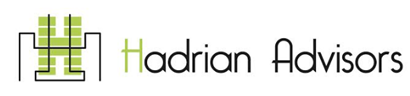

# Introduction to Neural Network Methodology in <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a>  : Feed-Forward and Backpropagation in a Two-Layers Neural Network 

## 1. Data Preparation

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn
import gc
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
## read datasets
pathData = ''

train = pd.read_csv(pathData+'trainDataset.csv')
Y = train['target'].as_matrix()
DF_X = train.drop('target',axis=1)

test =  pd.read_csv(pathData+'testDataset.csv')
Y_test = test['target'].as_matrix()
DF_X_test = test.drop('target',axis=1)


In [3]:
## Transform the types of each column
for c in DF_X.columns:
    if 'Cat_' in c:
        DF_X[c] = DF_X[c].astype(str)
        DF_X_test[c] = DF_X_test[c].astype(str)
    else:
        DF_X[c] = DF_X[c].astype(float)
        DF_X_test[c] = DF_X_test[c].astype(float)

### Categorization of the output variable

In [4]:
# Categorization
treshold_ExLR = 0.75

Id_0_train = np.nonzero(Y<treshold_ExLR)[0]
Id_0_test = np.nonzero(Y_test<treshold_ExLR)[0]

Id_1_train = np.nonzero(Y>=treshold_ExLR)[0]
Id_1_test = np.nonzero(Y_test>=treshold_ExLR)[0]

Y[Id_0_train] = 0
Y[Id_1_train] = 1

Y_test[Id_0_test] = 0
Y_test[Id_1_test] = 1

### Encoding the categorical variables

In [5]:
# Encode categorical variables
DF_X = DF_X.copy()
DF_X_test = DF_X_test.copy()
for var in DF_X.columns:
    if str(DF_X[var].dtypes)=='object':
        le = LabelEncoder().fit(DF_X[var])
        DF_X[var] = le.transform(DF_X[var])
        DF_X_test[var] = le.transform(DF_X_test[var])

## 2. Get the most important features

We want to use the most important features in DF_X using the Random Forest Classifier. The Gini criterion would be useful to do so.

In [6]:

# Var importance using RF classifier
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(random_state=0, n_estimators=100,\
                                  criterion='gini',max_depth=5)
VarImp = estimator.fit(DF_X,Y).feature_importances_

In [7]:
VarToUse = np.array(DF_X.columns.tolist())[np.argsort(-VarImp)[:10]]
print("List of the 5 features to use : ")
print(VarToUse)

List of the 5 features to use : 
['Num_Car11' 'Num_Car15' 'Num_Car9' 'NumInsurance13' 'NumInsurance11'
 'Cat_Insurance4' 'Cat_Insurance3' 'NumInsurance12' 'Num_Car19'
 'NumInsurance16']


**We can now extract these features, along with a random sample of the rows.**

In [8]:
# Sampling

sizeSample = 5000
IdRand = np.sort(np.random.permutation(np.arange(len(Y)))[:sizeSample])
X_sample = DF_X[VarToUse].as_matrix()[IdRand]
Y_sample = Y[IdRand]

X_test = DF_X_test[VarToUse].as_matrix()

print('X sample')
print(X_sample[:5])

print
print('Y sample')
print(Y_sample[:5])

X sample
[[  3.00000000e+00   2.00000000e+00   1.37080000e+04   4.50726853e+03
    3.47754683e+02   2.00000000e+00   2.00000000e+00   7.71541967e-02
    9.39000000e+02   5.13554623e+03]
 [  9.00000000e+00   1.00000000e+00   1.85500000e+04   2.99674847e+03
    3.19359963e+02   1.00000000e+00   1.00000000e+00   1.06568825e-01
    1.37500000e+03   4.50849471e+03]
 [  1.30000000e+01   1.00000000e+00   3.90000000e+03   1.56231210e+03
    1.64005209e+02   1.00000000e+00   1.00000000e+00   1.04975958e-01
    7.35000000e+02   4.70934867e+03]
 [  7.00000000e+00   1.00000000e+00   2.47800000e+04   3.36911266e+03
    4.07660613e+02   1.00000000e+00   1.00000000e+00   1.20999401e-01
    1.53800000e+03   4.47663540e+03]
 [  1.40000000e+01   1.00000000e+00   7.50000000e+03   1.83141486e+03
    1.99324422e+02   1.00000000e+00   1.00000000e+00   1.08836303e-01
    1.18000000e+03   4.75575330e+03]]

Y sample
[ 0.  0.  1.  0.  0.]


### 3. Two Hidden Layers Neural network : Implementation

Let's define error functions and their cost derivatives :

In [9]:
def MSE(y,ychap):
    return sum((ychapy-y)**2)


def MSEDer(y,ychap):
    return (ychap-y)


Let's define some activation functions and their derivatives; by default, we will take the sigmoid function.

In [10]:
# activation function in this case Sigmoid
def sigmoid(x): 
    return 1./(1+np.exp(-x))     # activation function

def sigmoid_prime(x): 
    return sigmoid(x)*(1-sigmoid(x))           # derivative of sigmoid

# activation function of Exponential linear unit
def ELU(x):
    res = 0.01 * (np.exp(x) - 1) * (x < 0) + x * (x >= 0)
    return res

# Derivative of Exponential linear unit
def ELU_prime(x):
    res = (ELU(x) + 0.01) * (x < 0) + 1.0 * (x >= 0)
    return res

# activation function of Rectified linear unit
def ReLU(x):
    res = 0.01*x*(x < 0) + x * (x >= 0)
    return res

# Derivative of Rectified linear unit
def ReLU_prime(x):
    res = 1.0 * (x >= 0) + 0.01 * (x < 0)
    
    return res

**/!\ Make sure to normalize your data before processing the propagation! **

In [11]:
# Normalization
from sklearn.preprocessing import MinMaxScaler
normX = MinMaxScaler()
normX.fit(X_sample)
X_sample_norm = normX.transform(X_sample)
X_test_norm = normX.transform(X_test)

In [12]:
def encode_label(j):
    e = np.zeros((2, 1))
    e[int(j)] = 1.0
    return e


def shape_data(data, encode=True):
    features = [x for x in data[0]]
    if encode:
        labels = [encode_label(y) for y in data[1]]
    else:
        labels = data[1]
    return list(zip(features, labels))

**Merge X and Y**

In [13]:
train_data = (X_sample_norm, Y_sample)
test_data = (X_test_norm, Y_test)

train_data = shape_data(train_data, encode=False)
test_data = shape_data(test_data, encode=False)

print(train_data[0])

(array([ 0.06976744,  0.33333333,  0.05652387,  0.23046397,  0.10552162,
        0.5       ,  0.5       ,  0.08894291,  0.19023569,  0.27127219]), 0.0)


In [14]:
Y_encoded = [val[1] for val in train_data]

#### a) Initialization and test on one example (row)

**Let's try the process on one example.**

*INITIALIZATION*

In [63]:
# Initialisation
alpha = 0.1
input_dim = len(train_data[0][0])
hidden_dim = 2
output_dim = 1

# Weight for Hidden Layer
Whidden = 2*np.random.random((hidden_dim,input_dim))-1
# Bias for Hidden Layer
bhidden = 2*np.random.random((hidden_dim,1))-1

# Weight for Output Layer
Wout = 2*np.random.random((output_dim,hidden_dim))-1
# Bias for Output Layer
bout = 2*np.random.random((output_dim,1))-1



print(Whidden.shape)
print(Wout.shape)

(2L, 10L)
(1L, 2L)


**We also initialize the deltas.**

In [64]:
deltaWhidden = np.zeros(Whidden.shape)
deltabhidden = np.zeros(bhidden.shape)

deltaWout = np.zeros(Wout.shape)
deltabout = np.zeros(bout.shape)

**Let's begin the forward propagation on one example!**

*FORWARD PROPAGATION*

**Exercice : **

Complete the script below, computing the hidden layer and the activation function.

In [65]:
## forward propagation
InitialLayer = train_data[0][0]
InitialLayer = np.vstack(InitialLayer)

HiddenLayers = None
HiddenLayersActivation = None
############### ENTER YOUR CODE HERE ###############
## Hidden Layer
HiddenLayers = np.dot(Whidden,InitialLayer) + bhidden
## Activation Hidden Layer
HiddenLayersActivation = sigmoid(HiddenLayers)
############### END OF THE CODE ################

## Output Layer
OutputLayer = np.dot(Wout,HiddenLayersActivation) + bout
## Activation Layer
Output = sigmoid(OutputLayer)


**Let's print the shapes of each DENSE layer : **

In [66]:
print(' X = InputLayer,  input matrix')
print(InitialLayer.shape)

print

print('HiddenLayer')
print(HiddenLayers.shape)

print

print('OutputLayer')
print(OutputLayer.shape)

 X = InputLayer,  input matrix
(10L, 1L)

HiddenLayer
(2L, 1L)

OutputLayer
(1L, 1L)


*ACTIVATION ERROR*

*Let's compute the error of activation; We assume that we are using the MSE (Mean Squared Error)*

In [67]:

## Error computation
errorFunc = MSEDer
error = errorFunc(Y_encoded[0], OutputLayer)
print(error)

[[ 0.17068878]]


*BACK PROPAGATION*

*First, get the deltas of the output layer* :

In [68]:

## Back propagation steps
OutputLayerActivation_d = error
OutputLayer_d = OutputLayerActivation_d * sigmoid_prime(OutputLayer)

## Update the costs on the output dense layer :
deltaWout += 0
deltabout += 0
############### ENTER YOUR CODE HERE ###############
deltaWout += np.dot(OutputLayer_d, HiddenLayersActivation.T)
deltabout += OutputLayer_d
############### END OF THE CODE ###############

print('Delta Error on Activaton Layer, Format :')
print(OutputLayerActivation_d.shape)

print


Delta Error on Activaton Layer, Format :
(1L, 1L)



*Then, get the deltas of the hidden layer* :

In [69]:
HiddenLayerActivation_d = np.dot(Wout.T,OutputLayer_d)

HiddenLayer_d = HiddenLayerActivation_d * sigmoid_prime(HiddenLayers)

print(HiddenLayers.shape)

(2L, 1L)




## Update the costs on the hidden dense layer :


In [70]:
deltaWhidden += 0
deltabhidden += 0
############### ENTER YOUR CODE HERE ###############
deltaWhidden += np.dot(HiddenLayer_d, InitialLayer.T)
deltabhidden += HiddenLayer_d
############### END OF THE CODE ###############

print('Delta Error on Hidden Layer, Format :')
print(HiddenLayerActivation_d.shape)

Delta Error on Hidden Layer, Format :
(2L, 1L)


*UPDATING THE WEIGHT AND THE BIAS*

In [71]:
# upgrade weights and bias for Output layer
mini_batch_size = 100
Wout -= alpha/mini_batch_size * deltaWout
bout -= alpha/mini_batch_size * deltabout
print(Wout.shape)
print(bout.shape)


(1L, 2L)
(1L, 1L)


In [72]:
# upgrade weights and bias for Hidden layers
Whidden -= alpha/mini_batch_size * deltaWhidden
bhidden -= alpha/mini_batch_size * deltabhidden
print(Whidden.shape)
print(bhidden.shape)

(2L, 10L)
(2L, 1L)


Here are the results from that computation : 

In [73]:
print('Whidden :')
print(Whidden)
print
print('bhidden :')
print(bhidden)

print('Wout :')
print(Wout)
print
print('bout :')
print(bout)

Whidden :
[[ 0.62354094  0.56474896 -0.95904579 -0.38674205  0.31417622  0.08986493
   0.4378286  -0.68497132 -0.92165907 -0.99291818]
 [ 0.11809822 -0.92605483 -0.09311734  0.39602963 -0.95949685 -0.61777698
  -0.94291915 -0.50664231 -0.94227641  0.46656809]]

bhidden :
[[-0.83281566]
 [-0.17719258]]
Wout :
[[-0.7951167  -0.42039013]]

bout :
[[ 0.31396351]]


#### b) Epochs and Mini_batchs :

Let's define the function to update the weights and the biases on a mini-batch.

In [56]:
def Train_Batch(mini_batch,Whidden,bhidden,Wout,bout,hidden_layer_dim,alpha=0.1):
    
    """
    Updates the weight matrix W and the bias vector b of a one-layer neural network, given a mini-batch of examples
    and alpha the learning rate.
    
    Arguments:
    mini_batch -- learning set
    Whidden -- hidden weight matrix
    bhidden -- hidden bias vector
    Wout -- output weight matrix
    bout -- output bias vector
    alpha -- learning rate
    
    Returns:
    Whidden -- updated hidden weight matrix
    bhidden -- updated hidden bias vector
    Wout -- updated output weight matrix
    bout -- updated output bias vector
    
    
    """
    
    input_dim = len(mini_batch[0][0])
    deltaWhidden = np.zeros((hidden_layer_dim,input_dim))
    deltabhidden = np.zeros((hidden_layer_dim,1))

    deltaWout = np.zeros((1,hidden_layer_dim))
    deltabout = np.zeros((1,1))
    for x, y in mini_batch:
        # forward propagation
        InitialLayer = np.vstack(x)

        HiddenLayers = np.dot(Whidden,InitialLayer) + bhidden
        HiddenLayersActivation = sigmoid(HiddenLayers)

        OutputLayer = np.dot(Wout,HiddenLayersActivation) + bout
        Output = sigmoid(OutputLayer)
        
        # Error computation
        OutputLayerAct_d = Output - (1.*y)
        
        # => back propagation steps
        OutputLayer_d = OutputLayerAct_d * sigmoid_prime(OutputLayer)

        deltaWout += np.dot(OutputLayer_d, HiddenLayersActivation.T)
        deltabout += OutputLayer_d

        HiddenLayerAct_d = np.dot(Wout.T,OutputLayer_d)
        HiddenLayer_d = HiddenLayerAct_d * sigmoid_prime(HiddenLayers)

        deltaWhidden += np.dot(HiddenLayer_d, InitialLayer.T)
        deltabhidden += HiddenLayer_d
        

    # upgrade weights and bias for Output layer
    Wout -= alpha/len(mini_batch) * deltaWout
    bout -= alpha/len(mini_batch) * deltabout
    # upgrade weights and bias for Hidden layer
    Whidden -= alpha/len(mini_batch) * deltaWhidden
    bhidden -= alpha/len(mini_batch) * deltabhidden

    return Whidden, bhidden, Wout, bout

We can define a Prediction function, given the weights and biases.

** Exercice ** :

Complete the prediction function below, that computes a prediction of a two-layers neural network

In [57]:
def Predict(X,Whidden,bhidden,Wout,bout):
    
    XT = np.vstack(X)
    dim = XT.size
    if XT.shape[1] > 1:
        XT = XT.T
    print
    
    HiddenLayersActivation = None
    Output = None
    ############ ENTER YOUR CODE HERE ############
    HiddenLayersActivation = sigmoid(np.dot(Whidden,XT) + bhidden)
    Output = sigmoid(np.dot(Wout,HiddenLayersActivation) + bout)
    ############ END OF THE CODE #############
    Output = Output[0]
    return Output

**DUMMY EXAMPLE **

In [58]:
Predict([0] * len(Whidden[0]),Whidden,bhidden,Wout,bout)

array([ 0.11043402])

Let's compute that algorithm on every example from the training set.

In order to update the weight matrix and the bias vector on "batches" of the training set, ie in order to better fit the model using groups of points, we could use the "mini-batch" method : we split examples in samples of the same size, and we compute the forward-propagation and back-propagation on these subsets; then we update the weights and the biases.



We now iterate over the training set and create mini_batches of 500 examples. We generate 10 epochs to do so.

In [59]:
# initial alpha
alpha = 0.1
mini_batch_size = 10
n_train = len(train_data)

# Dimensions
input_dim = len(train_data[0][0])
hidden_layer_dim = 10
output_layer_dim = 1

# Hidder Dense Layer
Whidden = 2*np.random.random((hidden_layer_dim,input_dim))-1
bhidden = 2*np.random.random((hidden_layer_dim,output_layer_dim))-1

# Output Dense Layer
Wout = 2*np.random.random((output_layer_dim,hidden_layer_dim))-1
bout = 2*np.random.random((output_layer_dim,output_layer_dim))-1


for epochs in range(50):
    if epochs % 10 == 0:
        print(epochs)
    # shuffle the raining set to then split it into mini_batches :
    np.random.shuffle(train_data)
    mini_batches = [train_data[k:k + mini_batch_size]
                    for k in range(0, n_train, mini_batch_size)]
    for mini_batch in mini_batches:
        Whidden,bhidden,Wout,bout = Train_Batch(mini_batch,Whidden,bhidden,Wout,bout,hidden_layer_dim,alpha)


0
10
20
30
40


** Prediction on training and test sets ** :

In [60]:
# prediction on train sample
X_train_norm = normX.transform(DF_X[VarToUse].as_matrix())
nnetPredTrain = Predict(X_train_norm,\
                       Whidden,bhidden,Wout,bout)

# prediction on test sample
X_test_norm = normX.transform(DF_X_test[VarToUse].as_matrix())
nnetPredTest = Predict(X_test_norm,\
                       Whidden,bhidden,Wout,bout)


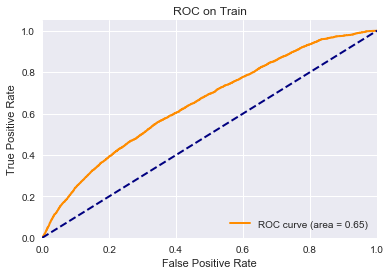

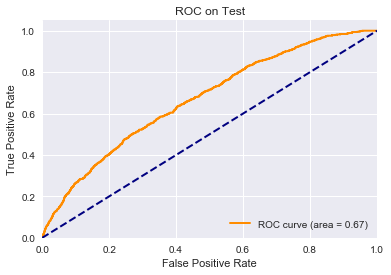

In [61]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(Y.astype(int),nnetPredTrain)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on Train')
plt.legend(loc="lower right")
plt.show()


fpr_test, tpr_test, _ = roc_curve(\
                Y_test,nnetPredTest)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on Test')
plt.legend(loc="lower right")
plt.show()

In [62]:
nnetPredTrain

array([ 0.08406152,  0.1157721 ,  0.05184739, ...,  0.11658193,
        0.11690858,  0.11721143])